In [1]:
import sys 
sys.path.append('..')
from cox.utils import Parameters
from cox.store import Store
from cox.readers import CollectionReader
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import itertools
import numpy as np
from scipy.spatial.distance import mahalanobis
import torch as ch
from torch import Tensor
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.utils.data import DataLoader
from delphi.stats.censored_multivariate_normal import censored_multivariate_normal
from delphi.utils.datasets import CensoredMultivariateNormalDataset as censored_dataset
from delphi.oracle import Left, Interval
from delphi.utils.constants import COSINE
import datetime

# Helpers

In [2]:
STORE_PATH = '/home/pstefanou/censored_multi'
STORE_TABLE_NAME = 'censored_df'

store = Store(STORE_PATH)

store.add_table(STORE_TABLE_NAME, { 
    'delphi_kl': float,
    'naive_kl': float,
    'alpha': float, 
    'C': float,
})

Logging in: /home/pstefanou/censored_multi/b924fc3f-6d10-4772-bf1f-2343cd241f7a


## Default Experiment Parameters

In [3]:
# regression parameters
NUM_SAMPLES, DIMS = 10000, 2

# procedure hyperparameters
args = Parameters({ 
    'epochs': 25,
    'num_workers': 0, 
    'batch_size': 10,
    'bias': True,
    'clamp': True, 
    'radius': 5.0, 
    'lr': 1e-1,
    'shuffle': False, 
    'tol': 5e-3,
    'custom_lr_multiplier': COSINE
})

In [4]:
# perform each experiment a total of 10 times
for iter_ in range(10): 
    for C in [.5, -1, -.5, 0, .5]:
        PREDICATE = Left(ch.full(ch.Size([1, DIMS]), C))
        args.__setattr__('phi', PREDICATE)
        # generate random uniform weights
        M = MultivariateNormal(ch.zeros(DIMS), ch.eye(DIMS))
        samples = M.sample(ch.Size([NUM_SAMPLES]))
        S = samples[PREDICATE(samples).nonzero(as_tuple=False).flatten()]

        args.__setattr__('alpha', Tensor([S.size(0) / NUM_SAMPLES]))

        # truncated logistic regression
        data = censored_dataset(S)
        S = DataLoader(data, batch_size=args.batch_size, num_workers=args.num_workers, shuffle=args.shuffle)
        censored = censored_multivariate_normal(phi=args.phi, alpha=args.alpha, bias=args.bias, epochs=args.epochs, 
                                                      lr=args.lr, tol=args.tol, custom_lr_multiplier=COSINE)
        results = censored.fit(S)

        # metrics
        delphi_kl = ch.distributions.kl.kl_divergence(M, results)
        naive_kl = ch.distributions.kl.kl_divergence(M, MultivariateNormal(S.dataset.loc, S.dataset.covariance_matrix))

        store[STORE_TABLE_NAME].append_row({ 
            'delphi_kl': delphi_kl,
            'naive_kl': naive_kl,
            'alpha': float(args.alpha),
            'C': C,
        })

# close current store
store.close()


avg score: 
 tensor([ 0.0185, -0.0095, -0.0200, -0.0019, -0.0019,  0.0206])


# Results

In [5]:
reader = CollectionReader(STORE_PATH)
df = reader.df(STORE_TABLE_NAME)
reader.close() # close reader
df.head()

100%|██████████| 1/1 [00:00<00:00, 121.21it/s]


,delphi_kl,naive_kl,alpha,C,exp_id
0,2.544774,6.318393,0.0911,0.5,b924fc3f-6d10-4772-bf1f-2343cd241f7a
1,0.165274,0.265044,0.7081,-1.0,b924fc3f-6d10-4772-bf1f-2343cd241f7a
2,0.340603,0.872034,0.4805,-0.5,b924fc3f-6d10-4772-bf1f-2343cd241f7a
3,0.707235,2.384263,0.2485,0.0,b924fc3f-6d10-4772-bf1f-2343cd241f7a
4,1.562600,5.903477,0.0943,0.5,b924fc3f-6d10-4772-bf1f-2343cd241f7a


# All Trials

In [6]:
len(df)

50

all trials:


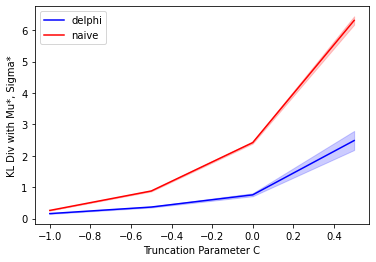

In [7]:
print("all trials:")

# variance vs param mse
sns.lineplot(data=df, x='C', y='delphi_kl', label='delphi', color='blue')
ax = sns.lineplot(data=df, x='C', y='naive_kl', label='naive', color='red')
ax.set(xlabel='Truncation Parameter C', ylabel='KL Div with Mu*, Sigma*')
plt.show()

In [8]:
results.loc, results.covariance_matrix

(tensor([0.3794, 0.6641], requires_grad=True),
 tensor([[1.0783, 0.2044],
         [0.2044, 1.2288]], requires_grad=True))

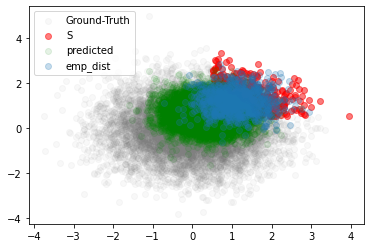

In [11]:
plt.scatter(samples[:,0], samples[:,1], color="grey", alpha=.05, label="Ground-Truth")
emp = samples[PREDICATE(samples).nonzero(as_tuple=False).flatten()]
plt.scatter(emp[:,0], emp[:,1], color="red", label="S", alpha=.5)
pred = results.sample(ch.Size([10000]))
plt.scatter(pred[:,0], pred[:,1], label="predicted", color="green", alpha=.1)
trunc = MultivariateNormal(S.dataset.loc, S.dataset.covariance_matrix).sample(ch.Size([1000]))
plt.scatter(trunc[:,0], trunc[:,1], label="emp_dist", alpha=.25)
plt.legend()

plt.show()